## **Random Forest**

El dataset de accidentes en Estado Unidos tiene una columna de Severity en la cual se etiquearon y se clasificaron los incidentes en una escala de 1 a 4, donde 1 indica el menor impacto en el trafico vehicular, es decir es decir, un breve retraso como resultado del accidente. Por su parte 4 indica un impacto significante en el trafico vehicular, es decir un tiempo de retraso prolongado a la circulacion.

Debido a que tenemos las etiquetas de salida de los datos, se planeto un algoritmo de de clasificacion, y debido a que muchas de las variables del dataset son categoricas (variables de puntos de interes), se obto por usar Random Forest el cual funciona bien para variables de este tipo.

El objetivo de este clasificador es poder predecor de manera precisa la severidad de los accidentes y tambien poder identificar los factores claves que afectan la severidad de estos. Se debe tomar en cuenta que el clasificador no tomara en cuenta informacion detallada del causante del accidente como informacion del conductor o tipo de vehiculo involucrado, ya que el dataset no cuenta con esta informacion.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
!pip install -q kaggle


In [ ]:
## Descarga y lectura del Dataset #
#API de kaggle para descargar el dataset
import os
os.environ['KAGGLE_USERNAME'] ="sergiomr04" # username 
os.environ['KAGGLE_KEY'] = "7400f9c2913e5b4b8a17ab2661f963b6" # key 
!kaggle datasets download -d sobhanmoosavi/us-accidents # api copied from kaggle
!unzip -q us-accidents.zip -d .
os.remove("/content/us-accidents.zip")
accidentes = pd.read_csv("/content/US_Accidents_Dec20_Updated.csv")

# Delimitacion de los datos al Estado de California
acc_CA = accidentes[accidentes['State']=='CA'].reset_index(drop=True)
acc_CA.head()

 99% 287M/290M [00:02<00:00, 134MB/s]
100% 290M/290M [00:02<00:00, 129MB/s]
replace ./US_Accidents_Dec20_Updated.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
yes


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3,2,2020-12-13 21:53:00,2020-12-13 22:44:00,37.145730,-121.985052,37.165850,-121.988062,1.400,Stationary traffic on CA-17 from Summit Rd (CA...,NaN,Santa Cruz Hwy,R,Los Gatos,Santa Clara,CA,95033,US,US/Pacific,KSJC,2020-12-13 21:53:00,51.0,51.0,80.0,30.17,10.0,W,6.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-8,2,2019-12-21 23:59:00,2019-12-22 00:32:06,34.034017,-118.026972,34.034017,-118.026972,0.000,At CA-60/Pomona Fwy - Accident.,NaN,CA-60 W,R,Whittier,Los Angeles,CA,90601,US,US/Pacific,KEMT,2019-12-21 23:53:00,55.0,55.0,40.0,29.86,10.0,E,5.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-10,2,2019-01-30 08:44:18,2019-01-30 09:14:17,34.426330,-118.585100,34.420220,-118.581900,0.460,At Magic Mountain Pky - Accident. Hard shoulde...,NaN,Golden State Fwy S,R,Valencia,Los Angeles,CA,91355,US,US/Pacific,K3A6,2019-01-30 08:39:00,57.0,57.0,77.0,29.08,5.0,VAR,5.0,0.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
3,A-17,2,2016-07-09 14:54:01,2016-07-09 15:54:01,34.103172,-118.249969,34.103172,-118.249969,0.000,Accident on CA-2 Southbound at Exit 13 I-5.,NaN,CA-2 S,R,Los Angeles,Los Angeles,CA,90039,US,US/Pacific,KCQT,2016-07-09 14:47:00,78.1,NaN,60.0,29.99,10.0,Variable,3.5,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,A-18,2,2020-11-21 16:32:00,2020-11-21 20:18:30,34.186595,-117.439427,34.185871,-117.439039,0.055,Incident on SIERRA AVE near LYTLE CREEK RD Exp...,3738.0,Sierra Ave,R,Fontana,San Bernardino,CA,92336-1108,US,US/Pacific,KONT,2020-11-21 16:53:00,75.0,75.0,26.0,28.98,9.0,WSW,6.0,0.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


En base a lo anterior vamos a elegir las columnas necesarias, las caracteristicas que tomaremos en cuenta para nuestro modelo, se decidio eliminar la columna Wind_Chill(F) ya que ya cuenta con muchos nans y no es tan relevante ya que contamos con los datos de temperatura

In [ ]:
acc_CA_entradas = acc_CA[['Severity', 'Start_Time','Start_Lat', 'Start_Lng',
                          'Temperature(F)',
                          'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
                          'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
                          'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
                          'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
                          'Turning_Loop', 'Sunrise_Sunset']]

Una vez elegidas las caracteriticas o columnas, empezaremos a analizar la cantidad de datos nulos en nuestro set de datos, para empezar con la preparacion de estos para el desarollo del clasificador

In [ ]:
acc_CA = accidentes[accidentes['State']=='CA'].reset_index(drop=True)
acc_CA_entradas.isna().sum(axis=0)

Severity                  0
Start_Time                0
Start_Lat                 0
Start_Lng                 0
Temperature(F)        20693
Humidity(%)           21778
Pressure(in)          15765
Visibility(mi)        17295
Wind_Direction        18740
Wind_Speed(mph)       89848
Precipitation(in)    329994
Weather_Condition     17123
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
Sunrise_Sunset            6
dtype: int64

In [ ]:
acc_CA_entradas.shape

(730744, 26)

Como podemos ver existe una considerable cantidad de datos nulos, en especial en las columnas de Precipitacion y velocidad del viento, debido a que nuestro dataset es bastante extenso se opto por eliminar los registros con valores NaNs, quedando suficientes datos para el entrenamiento y prueba del modelo.

Tambien en el caso de la columna de precipitacion, debido a que los valores son muy pequeños en su mayoria, se obto por rellenar los valores NANs asignandole un valor de 0 a estos

In [ ]:
acc_CA_entradas['Precipitation(in)'] = acc_CA_entradas['Precipitation(in)'].fillna(0);

In [ ]:
acc_CA_entradas_clear = acc_CA_entradas.dropna(how='any')

In [ ]:
acc_CA_entradas_clear.isna().sum(axis=0)

Severity             0
Start_Time           0
Start_Lat            0
Start_Lng            0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
dtype: int64

In [ ]:
acc_CA_entradas_clear.shape

(632946, 26)

Una vez eliminado los valores NaN, se procede a hacer el Encoding o el mapeo de las variables categoricas en el data set, en el caso de las anotaciones o puntos de interes los cuales tienen un valor bool de True and False, no es necesario el Mapeo, ya que el algoritmo las reconocera como 0 y 1 respectivamente

In [ ]:
# Encoding de las variables categoricas mediante valores que van del 0 al valor total de las categorias, es decir
# 0 para la cetgoria uno 1 para la 2, etc
climas = list(acc_CA_entradas_clear["Weather_Condition"].unique())
num_clima = list(range(len(climas)))
val_replace_climas = dict(zip(climas, num_clima))

dir_viento = list(acc_CA_entradas_clear["Wind_Direction"].unique())
num_dir_viento = list(range(len(dir_viento)))
val_replace_viento = dict(zip(dir_viento, num_dir_viento))

dia = list(acc_CA_entradas_clear["Sunrise_Sunset"].unique())
num_dia = list(range(len(dia)))
val_replace_dia = dict(zip(dia, num_dia))

In [ ]:
#encoding de las variables Categoricas
acc_CA_entradas_clear["Weather_Condition"] = acc_CA_entradas_clear["Weather_Condition"].map(val_replace_climas);
acc_CA_entradas_clear["Wind_Direction"] = acc_CA_entradas_clear["Wind_Direction"].map(val_replace_viento);
acc_CA_entradas_clear["Sunrise_Sunset"] = acc_CA_entradas_clear["Sunrise_Sunset"].map(val_replace_dia);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# set de datos con el encoding
acc_CA_entradas_clear

,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
0,2,2020-12-13 21:53:00,37.145730,-121.985052,51.0,80.0,30.17,10.0,0,6.0,0.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0
1,2,2019-12-21 23:59:00,34.034017,-118.026972,55.0,40.0,29.86,10.0,1,5.0,0.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0
2,2,2019-01-30 08:44:18,34.426330,-118.585100,57.0,77.0,29.08,5.0,2,5.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,1
3,2,2016-07-09 14:54:01,34.103172,-118.249969,78.1,60.0,29.99,10.0,3,3.5,0.0,2,False,False,False,False,False,False,False,False,False,False,False,False,False,1
4,2,2020-11-21 16:32:00,34.186595,-117.439427,75.0,26.0,28.98,9.0,4,6.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730737,2,2020-05-03 14:50:00,37.238208,-121.762061,70.0,33.0,30.00,10.0,11,13.0,0.0,0,False,False,False,False,True,False,False,False,False,False,False,False,False,1
730739,2,2019-10-25 08:00:41,33.981899,-118.191948,66.0,33.0,29.81,10.0,10,0.0,0.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,1
730740,3,2017-08-24 07:53:55,34.231285,-118.266190,64.9,81.0,29.87,5.0,16,3.5,0.0,4,False,False,False,False,False,False,False,False,False,False,False,False,False,1
730741,3,2018-04-18 17:16:44,37.676400,-122.109800,57.9,37.0,30.06,10.0,17,8.1,0.0,9,False,False,True,False,False,False,False,False,False,False,False,True,False,1


Una vez codificadas las variables, se decidio extraer caracteristicas de la fecha de inicio del accidente, como lo son el mes, dia y hora. y mapearlas a valores numericos para que puedan ser usados por el modelo

In [ ]:
# Encoding la fecha de inicio del accidente y extrayendo caracteristicas importantes
acc_CA_entradas_clear['Start_Time'] = pd.to_datetime(acc_CA_entradas_clear['Start_Time'])
acc_CA_entradas_clear['Month'] = acc_CA_entradas_clear['Start_Time'].dt.month
acc_CA_entradas_clear['Day'] = acc_CA_entradas_clear['Start_Time'].dt.day
acc_CA_entradas_clear['Hour'] = acc_CA_entradas_clear['Start_Time'].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Finalmente nuestro Dataset con las entradas listas para nustro modelo es el siguiente:

In [ ]:
acc_CA_entradas_clear.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Month,Day,Hour
0,2,2020-12-13 21:53:00,37.145730,-121.985052,51.0,80.0,30.17,10.0,0,6.0,0.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0,12,13,21
1,2,2019-12-21 23:59:00,34.034017,-118.026972,55.0,40.0,29.86,10.0,1,5.0,0.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,0,12,21,23
2,2,2019-01-30 08:44:18,34.426330,-118.585100,57.0,77.0,29.08,5.0,2,5.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,30,8
3,2,2016-07-09 14:54:01,34.103172,-118.249969,78.1,60.0,29.99,10.0,3,3.5,0.0,2,False,False,False,False,False,False,False,False,False,False,False,False,False,1,7,9,14
4,2,2020-11-21 16:32:00,34.186595,-117.439427,75.0,26.0,28.98,9.0,4,6.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,1,11,21,16


Antes de empezar verificamos las caracteriticas y que relacion existe con nuestra salida que es Severidad, para esto graficamos un Heatmap

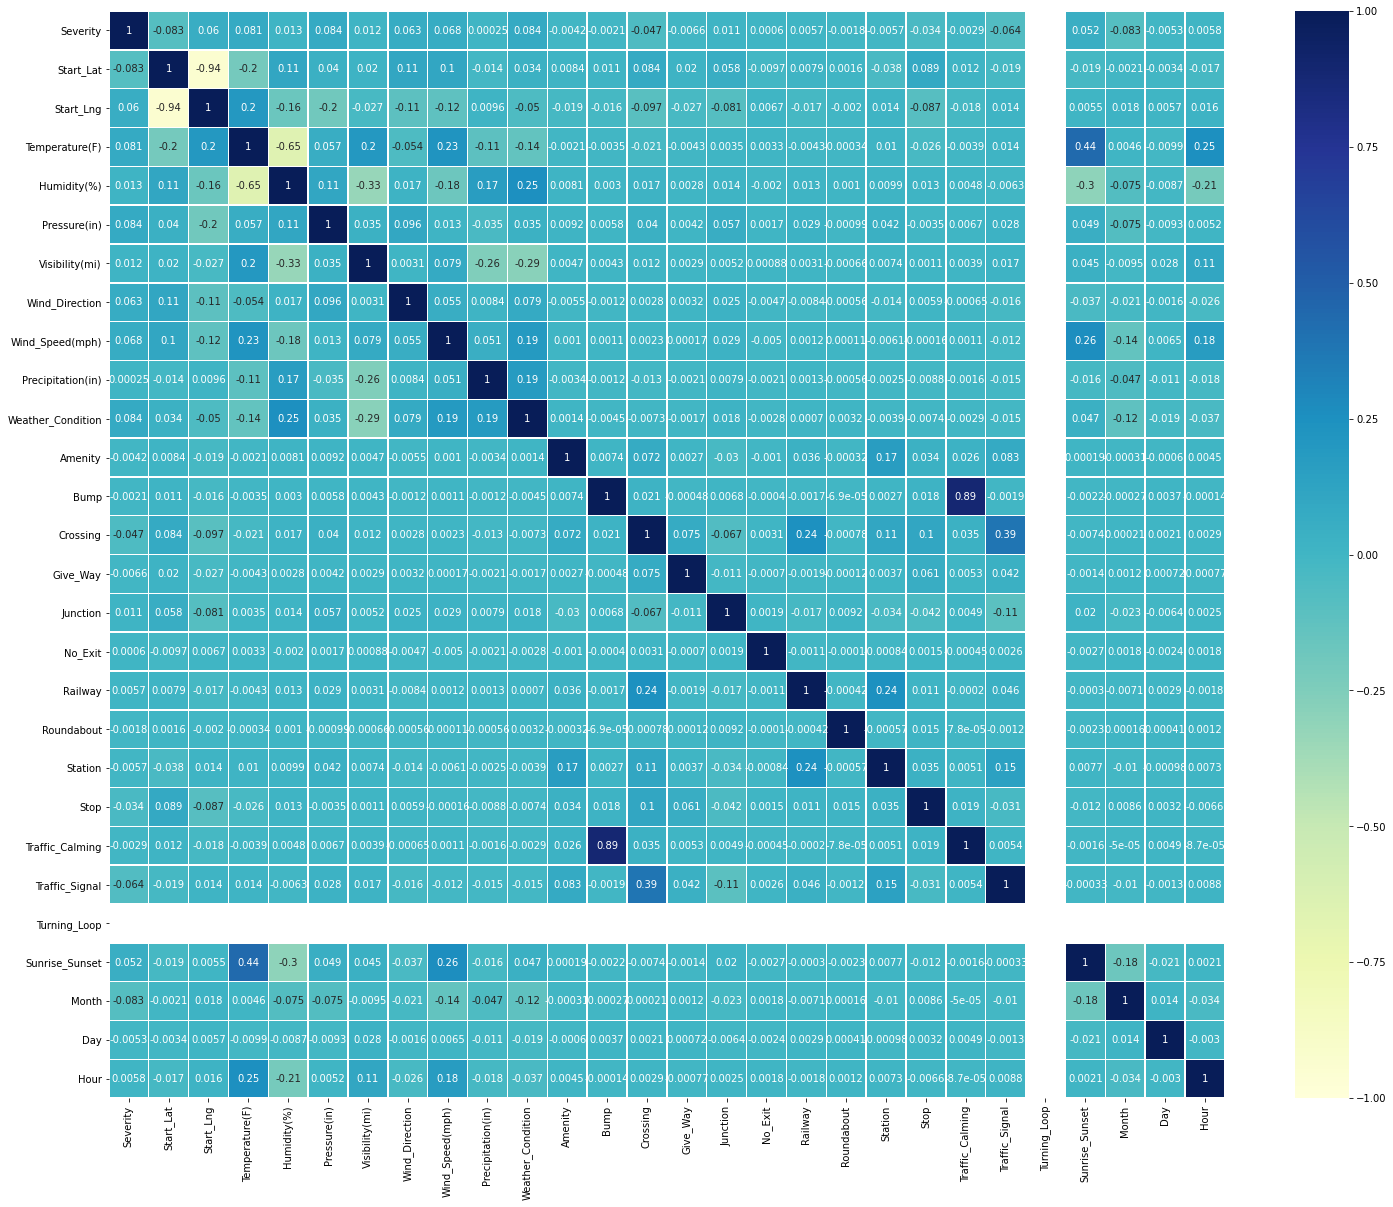

In [ ]:
plt.figure(figsize=(25, 20))
ax = sns.heatmap(acc_CA_entradas_clear.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);

DE acuerdo a lo anterior podemos percatarnos que no existen datos de Turning_loop por lo cual eliminamos esta columna de nuestros datos 

In [ ]:
acc_CA_entradas_clear.drop("Turning_Loop",axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
x=np.array(acc_CA_entradas_clear[acc_CA_entradas_clear.columns[2:]])            


In [ ]:
y=np.array(acc_CA_entradas_clear["Severity"])


Existen otras variables que parece no tienen relacion con severidad. Sin embargo cuando se ralizaron las corridas con los modelos se pudo constatar que el hetmap, no es tan preciso para determinar el peso de las carateristicas de las columnas.

# Eleccion del Modelo


---



Durante el Analisis exploratorio de los datos se detecto un desbalance en el numero de datos etiquetados por severidad, ya que hay una gran cantidad de datos catalogados como severidad 2, y muy pocos para las categorias 1 y 4. Esto lo podemos coprobar mediante lo siguiente>


In [ ]:
acc_CA_entradas_clear.groupby("Severity")[["Severity"]].count()

,Severity
Severity,
1,5499
2,513069
3,107612
4,6766


Como podemos ver la cantidad de datos con la etiqueta 2 supera por mucho las demas etiquetas. Para areglar este problema se plantearon 3 escenarios de solucion:

* Se utilizo un under sample o submuestreo para poder tener la misma cantidad de datos de todas las etiquetas, es decir, se remuestrearon los accidentes con severidad 2, 3 y 4 hasta obtener la misma cantidad de datos de la muestra menor, la cual es severidad 1.


* Se utilizo un oversample o sobremuestreo para poder tener la misma cantidad de datos para todas las categorias. El procedimiento es contrario al sunmuestreo, ya que en este se muestreo las severidades 1, 3 y 4 hasta obtener la misma cantidad de datos que la muestra con severidad 2.


* Se utilizo un Random Forest con los datos desbalanceados, sin embargo se calculo el peso de las clases o categorias y se incluyo en el modelo. Especificamente en el apartado class_wight



In [ ]:
## Modelo submuestreo esta comentado para evitar alojamiento en la memoria ##
#import numpy as np
#from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier as forest
#from sklearn.metrics import confusion_matrix
#from imblearn.under_sampling import NearMiss
#us=NearMiss()
##es posible que esta intruccion genere un error si se esta utilizando la version mas reciente de Imlearn
##basta con cambiar a .fit_resample
#x_train_us,y_train_us=us.fit_sample(x_train,y_train)
#from collections import Counter
#print(f"Numero de clases antes del undersample:{Counter(y_train)}")
#print(f"Numero de clases despues del undersample:{Counter(y_train_us)}")
#bosque = forest(n_estimators = 300,max_features='sqrt')
#bosque.fit(x_train_us, y_train_us)
#y_pred = bosque.predict(x_test)
#resultado = confusion_matrix(y_test, y_pred)
#print(resultado)
#diagonal = np.trace(resultado)
#accuracy = (diagonal / y_test.shape[0])*100
#print("Accuracy: "+str(accuracy)+"%")
#from sklearn.metrics import precision_recall_fscore_support as score
#presicion,recall,fscore,support=score(y_test,y_pred)
#print("presicion",presicion)
#print("recall",recall)
#print("fscore",fscore)
#print("support",support)

Utilizando el modelo de submuestreo se obtuvieron Accurancy de 9% a pesar de que se aumentaban el numero de arboles y de delimitaban el numero de caracteristicas o columnas los valores de accurancy no mejoraban muy probablemente debido a que se se reducia bastante el numero de datos, por lo cual se descarto este modelo.

In [ ]:
## Modelo Random Forest modificando los pesos de las clases#
#import numpy as np
#from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier as forest
#from sklearn.metrics import confusion_matrix
#from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train) ,y_train)
#class_weight
#bosque = forest(n_estimators = 300,max_features='sqrt',class_weight=class_weight1)
#bosque.fit(x_train, y_train)
#y_pred = bosque.predict(x_test)
#resultado = confusion_matrix(y_test, y_pred)
#print(resultado)
#resultado = confusion_matrix(y_test, y_pred)
#diagonal = np.trace(resultado)
#accuracy = (diagonal / y_test.shape[0])*100
#print("Accuracy: "+str(accuracy)+"%")
#from sklearn.metrics import precision_recall_fscore_support as score
#presicion,recall,fscore,support=score(y_test,y_pred)
#print("presicion",presicion)
#print("recall",recall)
#print("fscore",fscore)
#print("support",support)

Utilizando el metodo de random forest modificando los pesos de las clases seobtuvieron Accurancy de cerca del 80 % sin embargo los valores de recall y F-score para las clases 3 y 4 eran muy bajos (cerca de 0.3), comparados con los de la clase 2 (0.85). Por lo cual nuestro modelo estaba sobreprediciendo la clase 2. Por esta razon se obto por probar con otro modelo

El modelo con sobremuestreo es el que presento mejores resultados, en este apartado se utilizaron dos modelos diferentes. 
* Oversample muestreo aleatorio de las clases mas bajas 
* SMOTE muestreo aleatorio de las clases mas bajas por medio de k-nearest neighbors , se generan puntos sinteticos de la menor clase.

A pesar de que los dos modelos funcionan con el principio de sobremuestreo, ambos generan diferentes muestras, por lo cual los resultados de los modelos varian. En base a las corridas realizadas y los resultados obtenidos, el modelo de Oversample genero mejores resultados, ya que a pesar de obtener en mabos modelos accurancy de arriba del 80%. En el caso de SMOTE se lograron valores de F-score de 0.37 para la clase 4 y un recall de 0.29. En el caso de oversample que es el modelo que se eligio se llegaron alcanzar F-score de 0.43 y recall de 0.32.

In [ ]:
##Let us try some sampling technique to remove class imbalance
##from imblearn.over_sampling import SMOTE
##Over-sampling: SMOTE
#SMOTE (Técnica de sobremuestreo de minorías sintéticas) consiste en sintetizar elementos para la clase minoritaria,
#basados ​​en los que ya existen. Funciona seleccionando aleatoriamente un punto de la clase minoritaria y calculando
#los k vecinos más cercanos para este punto. Los puntos sintéticos se agregan entre el punto elegido y sus vecinos.
# Usaremos ratio = 'minority' para volver a muestrear la clase minoritaria.
#smote = SMOTE('minority')

#x_train ,x_test, y_train, y_test = train_test_split(x, y, test_size =0.40)
#X_sm, y_sm = smote.fit_sample(x_train, y_train)
#print(x_train.shape, y_train.shape)
#print(X_sm.shape, y_sm.shape)
#bosque = forest(n_estimators = 200,max_features='sqrt')
#bosque.fit(X_sm, y_sm)
#y_pred = bosque.predict(x_test)
#resultado = confusion_matrix(y_test, y_pred)
#print(resultado)
#diagonal = np.trace(resultado)
#accuracy = (diagonal / y_test.shape[0])*100
#print("Accuracy: "+str(accuracy)+"%")
#from sklearn.metrics import precision_recall_fscore_support as score
#presicion,recall,fscore,support=score(y_test,y_pred)
#print("presicion",presicion)
#print("recall",recall)
#print("fscore",fscore)
#print("support",support)

El modelo que genero mejores resultados fue el oversample y es el que saremos para mostrar los resultados, para consultas mas detalles acerca del Accurancy, recall, precision y F-score. Se puede consultar la bitacora.

In [ ]:
# Modelo Oversample
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as forest
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

us=RandomOverSampler()

x_train ,x_test, y_train, y_test = train_test_split(x, y, test_size =0.40)

#si esta intruccion da erro tratar con la intruccion de abajo
x_train_us,y_train_us=us.fit_sample(x_train,y_train)
#x_train_us,y_train_us=us.fit_resample(x_train,y_train)

#comparacion de los datos antes y despues del sobremuestreo
from collections import Counter
print(f"Numero de clases antes del oversample:{Counter(y_train)}")
print(f"Numero de clases despues del oversample:{Counter(y_train_us)}")


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Numero de clases antes del oversample:Counter({2: 307923, 3: 64524, 4: 4005, 1: 3315})
Numero de clases despues del oversample:Counter({2: 307923, 3: 307923, 4: 307923, 1: 307923})


Una vez que tenemos nuestro dataset balanceado procedemos a realizar el modelo de Random forest, primero queremos rectificar las caracteristicas que estan impactando al modelo por lo cual se correra con 50 arboles

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as forest
from sklearn.metrics import confusion_matrix

bosque = forest(n_estimators = 50,max_features='sqrt')
bosque.fit(x_train_us, y_train_us)
y_pred = bosque.predict(x_test)
resultado = confusion_matrix(y_test, y_pred)
print(resultado)
diagonal = np.trace(resultado)
accuracy = (diagonal / y_test.shape[0])*100
print("Accuracy: "+str(accuracy)+"%")
from sklearn.metrics import precision_recall_fscore_support as score
presicion,recall,fscore,support=score(y_test,y_pred)
print("presicion",presicion)
print("recall",recall)
print("fscore",fscore)
print("support",support)

[[  1148    969     58      9]
 [   517 189818  14541    270]
 [    55  26361  16560    112]
 [     8   1580    335    838]]
Accuracy: 82.29908483721003%
presicion [0.66435185 0.86782671 0.52581444 0.68185517]
recall [0.52564103 0.92528248 0.38432974 0.30351322]
fscore [0.58691207 0.89563408 0.44407498 0.42005013]
support [  2184 205146  43088   2761]


In [ ]:
features = list(acc_CA_entradas_clear[acc_CA_entradas_clear.columns[2:]].columns)
fi_model = pd.DataFrame({'feature': features,
                   'importance': bosque.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(30)

,feature,importance
0,Start_Lat,1.568245e-01
1,Start_Lng,1.489632e-01
23,Month,1.286887e-01
4,Pressure(in),8.311158e-02
2,Temperature(F),6.986741e-02
3,Humidity(%),6.811561e-02
24,Day,6.500256e-02
25,Hour,5.865254e-02
9,Weather_Condition,5.761801e-02
7,Wind_Speed(mph),5.678489e-02


Apartir de los pesos que tienen las diferetes columnas o caracteristicas sobre el modelo de Random forest, se determino que las columnas de "Bump", "Roundabout","No_Exit", "Give_Way", "Traffic_Calming","Railway", "Amenity" no tienen efecto relevante en el modelo por lo cual se decidio eliminarlas

In [ ]:
acc_CA_entradas_clear.drop(["Bump", "Roundabout","No_Exit", "Give_Way", "Traffic_Calming","Railway", "Amenity"],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


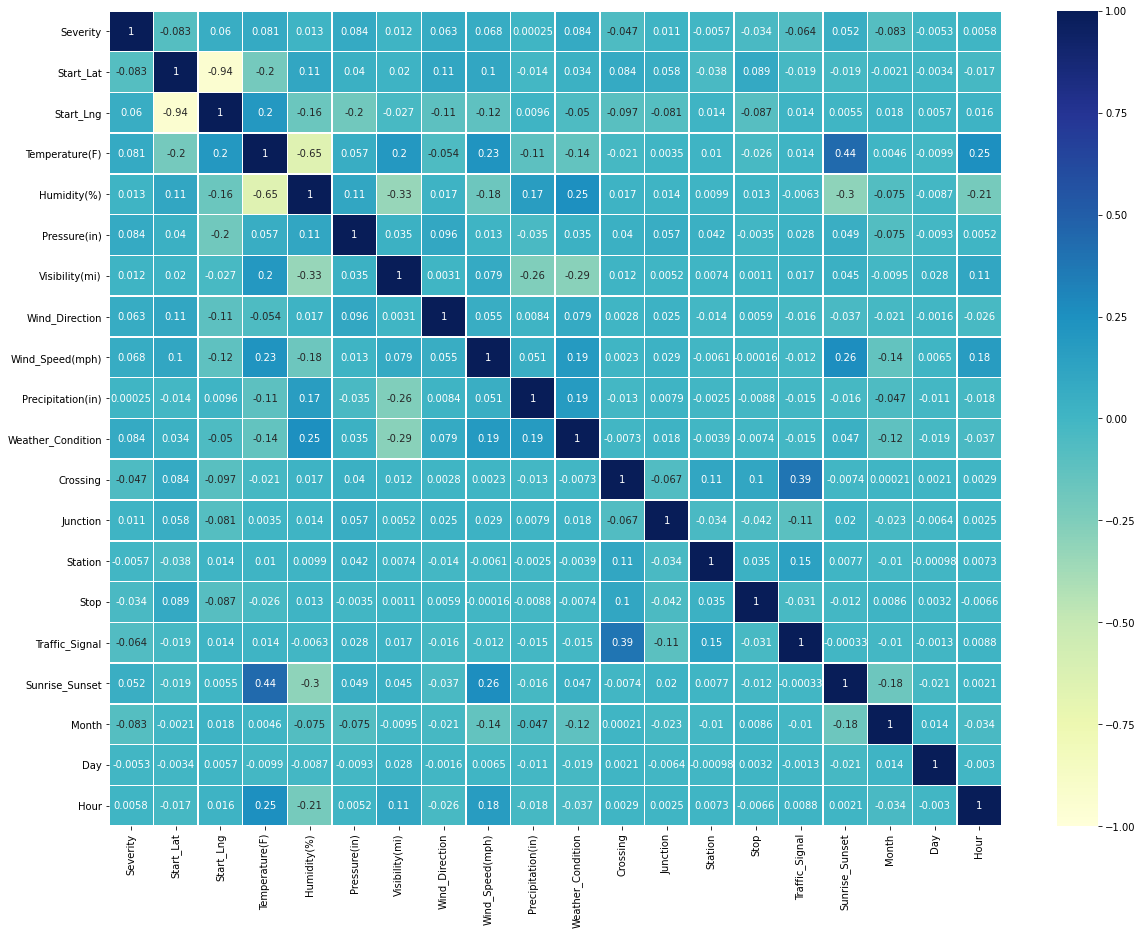

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.heatmap(acc_CA_entradas_clear.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);

Como Lo habiamos comnetado antes pareceria que variables como precipitacion no tienen impacto en el modelo, pero en realidad cuando calculamos los pesos, podemos ver que si impacta un poco mas de lo que aparece en el heatmap

A partir de diferentes corridas por el metodo de oversample, se determino que el numero de arboles optimo para el modelo esta en un rango de 200 a 220. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as forest
from sklearn.metrics import confusion_matrix

bosque = forest(n_estimators = 220,max_features='sqrt')
bosque.fit(x_train_us, y_train_us)
y_pred = bosque.predict(x_test)
resultado = confusion_matrix(y_test, y_pred)
print(resultado)
diagonal = np.trace(resultado)
accuracy = (diagonal / y_test.shape[0])*100
print("Accuracy: "+str(accuracy)+"%")
from sklearn.metrics import precision_recall_fscore_support as score
presicion,recall,fscore,support=score(y_test,y_pred)
print("presicion",presicion)
print("recall",recall)
print("fscore",fscore)
print("support",support)

[[  1144    969     64      7]
 [   477 190290  14117    262]
 [    46  26193  16739    110]
 [     7   1589    319    846]]
Accuracy: 82.55779507779081%
presicion [0.68339307 0.86874147 0.53583661 0.69061224]
recall [0.52380952 0.92758328 0.38848403 0.30641072]
fscore [0.5930534  0.89719864 0.45041506 0.4244857 ]
support [  2184 205146  43088   2761]


In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.52      0.59      2184
           2       0.87      0.93      0.90    205146
           3       0.54      0.39      0.45     43088
           4       0.69      0.31      0.42      2761

    accuracy                           0.83    253179
   macro avg       0.69      0.54      0.59    253179
weighted avg       0.81      0.83      0.81    253179

0.8255779507779081


A pesar de que el Accuracy mejoro, no significa que este modelo sea lo mejor, ya que al ser una clasificacion multi clase se tiene que tomar en cuenta los valores generados por el recall y el presicion los cuales se refieren a la proporción de identificaciones positivas que fue correcta y la proporción de positivos reales que se identificó correctamente. Siempre hay tensión entre precisión y recall, al mejorar la precisión, generalmente se reduce la recall, y viceversa. Sin embargo una metrica que nos ayuda a medir mejor la exactitud de nuestro modelo es el F-Score el cual entre mas cercano sea a 1 mejor la exactitud de nuestro modelo. Con nuestros datos apesar de aumentar el numero de arboles y variar las columnas para alimetar el modelo no se alcanzo el valor de 0.5 en las categorias 3 y 4. Por lo cual la exactitud en estas dos etiquetas nos tan buena como enla categoria 2. Sin embargo, esto es debido al gran numero de datos con etiqueta 2. De igual manera como se menciono en el analisis exploratorio, puede que muchos datos esten mal etiquetados, en especial los de la categoria 2.

Adicionalmente se pudo indetificar las variables clave que afectan la severidad de los accidentes, en este caso 